In [1]:
#Import needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from matplotlib import colors
# import cdflib
# from scipy.interpolate import RBFInterpolator

# #Use this to ignore warning in inerpolation script, maybe get rid of later to check for other issues
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None) #Change settings in Pandas so it shows all columns

In [2]:
#Constants
R = 8.314 #kgm^2s^-2K^-1mol^-1
h = 30 #Measurement height in m
L = 2.5*10**3 #Latent heat of vapoization of water at 0 deg C [J/g], should try to calc based on dependency on C
cp = 1005 #J/kg*K
mm = 0.02896 #kg/mol molar mass dry air
mm_w = 18.01 # molar mass of water [g/mol]
CtoK = 273.15 #Conversion from Celcius to Kelvin

In [3]:
#Read in all data

#Read in tower coords and set up dataframe
tc = pd.read_csv('../Inputs/tower_coords.csv') #datafrane of tower coordinates
tc.set_index('Tower', inplace = True)

#Convert lat and lon to coordinates in km, origin currently set to PFA coordinates, should change this since PFk is out of range
tc['x'] = (tc.Lon - tc.Lon['PFA'])*111*np.cos(tc.Lat['PFA']*np.pi/180)
tc['y'] = (tc.Lat - tc.Lat['PFA'])*111 


#Read in TA, H2O, and wind data
TA = pd.read_pickle('../Inputs/TA_orig_all.pickle')
H2O = pd.read_pickle('../Inputs/H2O_orig_all.pickle')
TA_grad = pd.read_pickle('../Inputs/TA_int_all.pickle')
H2O_grad = pd.read_pickle('../Inputs/H2O_int_all.pickle')
hrz_wind = pd.read_pickle('../Inputs/wind_dat.pickle')
vert_wind = pd.read_pickle('../Inputs/w_all.pickle')
PA_top = pd.read_pickle('../Inputs/PA_top.pickle')

#Rename vert_wind columns
tow_names =  dict(zip(tc.wind_var[1:], tc.index[1:]))
vert_wind = vert_wind.rename(columns = tow_names)

In [20]:
def WS_top_calc(tower, d_rat = 0.65):
    k = 0.4 #
    
    #Measurement height (z1 for all towers except PFA)

    h_tow = tc.z1.loc[tower]
        
    h_veg = tc.veg_h.loc[tower] #Vegetation height
    WS_calc = (hrz_wind.loc['Ustar'][tower]/k)*np.log((h_tow - d_rat*h_veg)/(0.1*h_veg))
    return WS_calc



def wind_prof(tower, step = 0.1):
    towdat = tc.loc[tower] #Tower data
    
    #Step is step size to be used for integration
    k = 0.4 #Von Karmann constant
    h_veg = tc.veg_h.loc[tower] #vegetation height
    h_tow = tc.z1.loc[tower] #tower height
    z_range = np.arange(0, h_tow + step, step)
    z_m = 0.1*h_veg #momentum friction parameter
    z_m_soil = 0.006 #From biophysic notes, check book Table_, ch.5
    
    d = 0.65*h_veg #zero plane displacement
    
    # d_mean = h_tow - z_m*np.exp(k*WS_top[tower]/Ustar[tower])#zero plane displacement, mean of val calculated for all timestamps
    
    WS_prof = pd.DataFrame() #windspeed profile
    
    
    WS_calc = WS_top_calc(tower)
    WS_calc_rat = hrz_wind.loc['WS_top'][tower]/WS_calc
    u_of_h = hrz_wind.loc['Ustar'][tower]/k*np.log((h_veg-d)/z_m)*WS_calc_rat #wind speed at top of canopy
    u_of_soil = u_of_h*np.exp(0.1 - 1) #WS at 0.1h, using exponential 
    ustar_soil = u_of_soil*k/np.log(0.1*h/z_m_soil) #Soil friction velocity, calculated from WS at 01.h
    
    
    for z in z_range: 
        if z >= h_veg:
            WS_prof[z] = hrz_wind.loc['Ustar'][tower]/k*np.log((z-d)/z_m)*WS_calc_rat
        elif z>=0.1*h_veg:
            WS_prof[z] = u_of_h*np.exp(z/h - 1)
        elif z>0:
            WS_prof[z] = ustar_soil/k*np.log((z)/z_m_soil)
        else:
            WS_prof[0] = 0
            
    return WS_prof




    
def prof_calcs(tower, step = 0.1):
    towdat = tc.loc[tower] #Tower data
    WS_prof = wind_prof(tower)
    
    h_tow = tc.z1.loc[tower] #tower height
    z_range = np.arange(0, h_tow + step, step)
    
    T_grad_NS, T_grad_EW = pd.DataFrame(), pd.DataFrame()
    H2O_grad_NS, H2O_grad_EW = pd.DataFrame(), pd.DataFrame()
    
   
    for z in z_range:     
        if towdat.z3 == 0:
            pass
        else:
            #should maybe make this more flexible for different tower heights
            T_grad_slope_NS_up = (TA_grad.loc['NS'].loc[30][tower] - TA_grad.loc['NS'].loc[10][tower])/20 #Slope of temp gradient from 10 to 30 m, NS
            T_grad_slope_EW_up = (TA_grad.loc['EW'].loc[30][tower] - TA_grad.loc['EW'].loc[10][tower])/20 #Slope of temp gradient from 10 to 30 m, EW
            T_grad_slope_NS_low = (TA_grad.loc['NS'].loc[10][tower] - TA_grad.loc['NS'].loc[2][tower])/8 #Slope of temp gradient from 2 to 10 m, NS
            T_grad_slope_EW_low = (TA_grad.loc['EW'].loc[10][tower] - TA_grad.loc['EW'].loc[2][tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
            H2O_grad_slope_NS_up = (H2O_grad.loc['NS'].loc[30][tower] - H2O_grad.loc['NS'].loc[10][tower])/20 #Slope of temp gradient from 10 to 30 m, NS
            H2O_grad_slope_EW_up = (H2O_grad.loc['EW'].loc[30][tower] - H2O_grad.loc['EW'].loc[10][tower])/20 #Slope of temp gradient from 10 to 30 m, EW
            H2O_grad_slope_NS_low = (H2O_grad.loc['NS'].loc[10][tower] - H2O_grad.loc['NS'].loc[2][tower])/8 #Slope of temp gradient from 2 to 10 m, NS
            H2O_grad_slope_EW_low = (H2O_grad.loc['EW'].loc[10][tower] - H2O_grad.loc['EW'].loc[2][tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
            if z >= towdat.z2:
                T_grad_NS[z] = TA_grad.loc['NS'].loc[10][tower] + T_grad_slope_NS_up*(z-towdat.z2)
                T_grad_EW[z] = TA_grad.loc['EW'].loc[10][tower] + T_grad_slope_EW_up*(z-towdat.z2)
                
                H2O_grad_NS[z] = H2O_grad.loc['NS'].loc[10][tower] + H2O_grad_slope_NS_up*(z-towdat.z2)
                H2O_grad_EW[z] = H2O_grad.loc['EW'].loc[10][tower] + H2O_grad_slope_EW_up*(z-towdat.z2)
            else:
                T_grad_NS[z] = TA_grad.loc['NS'].loc[10][tower] - T_grad_slope_NS_low*(towdat.z2 - z)
                T_grad_EW[z] = TA_grad.loc['EW'].loc[10][tower] - T_grad_slope_EW_low*(towdat.z2 - z)
                
                H2O_grad_NS[z] = H2O_grad.loc['NS'].loc[10][tower] - H2O_grad_slope_NS_low*(towdat.z2 - z)
                H2O_grad_EW[z] = H2O_grad.loc['EW'].loc[10][tower] - H2O_grad_slope_EW_low*(towdat.z2 - z)

                

            
    return WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW

    
    

In [21]:
#Hrz H and LE advection calcs

def hrz_ad_calc(tower, step = 0.1):

    WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW = prof_calcs(tower, step)
    
    TA_K = TA.loc[30][tower] + CtoK
    
    PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
    rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
    z = step #np.asarray(tc.loc[tower].z1) #Height of each tower

    SN_wind = WS_prof.mul(np.sin(hrz_wind.loc['WD'][tower]*np.pi/180), axis = 0)
    WE_wind = WS_prof.mul(np.cos(hrz_wind.loc['WD'][tower]*np.pi/180), axis = 0)
    
    #H advection
    H_SN = T_grad_NS*SN_wind.mul(-rho*z*cp/2000, axis = 0) #Advection of sensible heat by southerly wind [W/m^2]
    H_WE = T_grad_EW*WE_wind.mul(-rho*z*cp/2000, axis = 0) #Advection of sensible heat by westerly wind [W/m^2]
    H_ad = H_SN + H_WE #Total advection

    #LE advection
    LE_SN = H2O_grad_NS*SN_wind.mul(-z*L/2000) #Advection of latend heat by southerly wind [W/m^2]
    LE_WE = H2O_grad_EW*WE_wind.mul(-z*L/2000 )#Advection of latent hear by westerly wind [W/m^2]
    LE_ad = (LE_SN + LE_WE)#*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


    # hrz_ad = (H_ad + LE_ad)
    H_ad_tot = H_ad.sum(axis = 1)
    LE_ad_tot = LE_ad.sum(axis = 1)
    
    return H_ad_tot, LE_ad_tot
    #Deal with water vapor later
    # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

In [22]:
#Vert H and LE advection calcs

def vert_ad_calc(tower, step = 0.1):

    WS_prof = wind_prof(tower, step)
    
    #Calc vert T diff (only works for 30 m towers(only works for 30 m towers
    TA_30 = TA.loc[30][tower]
    TA_10 = TA.loc[10][tower]
    TA_2 = TA.loc[2][tower]
    TA_0 = TA_2 - (TA_10 - TA_2)*(2/8) #Surface temp
    TA_diff = TA_0 - TA_30 #Mistakenly had TA_10 instead of TA_0, fixed 11/1/2023
    
    #Vert [H2O] diff (only works for 30 m towers)
    H2O_30 = H2O.loc[30][tower]
    H2O_10 = H2O.loc[10][tower]
    H2O_2 = H2O.loc[2][tower]
    
    H2O_0 = H2O_2 - (H2O_10 - H2O_2)*(2/8) #Surface temp
    H2O_diff = H2O_0 - H2O_30 
    
    
    TA_K = TA_30 + CtoK #Change for shorter towers
    PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
    rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
    
    H_vert = TA_diff*vert_wind[tower]*rho*cp
    LE_vert= H2O_diff*vert_wind[tower]*L
    
    # H_vert = vert_wind[tower]
    # LE_vert= vert_wind[tower]*L
    
    
    return H_vert, LE_vert
    
    # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

In [23]:
#Calc hrz adv for all 30 m towers (fiture out shorter towers later)
H_hrz_all = pd.DataFrame()
LE_hrz_all = pd.DataFrame()

for tower in tc.index:
    if tc.loc[tower].z1 == 30:
        H_hrz, LE_hrz = hrz_ad_calc(tower)
        H_hrz_all[tower] = H_hrz
        LE_hrz_all[tower] = LE_hrz
        
hrz_ad = pd.concat([H_hrz_all, LE_hrz_all], keys = ['H', 'LE'])   

In [24]:
#Calc hrz adv for all 30 m towers (fiture out shorter towers later)
H_vert_all = pd.DataFrame()
LE_vert_all = pd.DataFrame()

for tower in tc.index:
    if tc.loc[tower].z1 == 30:
        if tower == 'PFA':
            pass
        else:
            H_vert, LE_vert = vert_ad_calc(tower)
            H_vert_all[tower] = H_vert
            LE_vert_all[tower] = LE_vert
        
vert_ad = pd.concat([H_vert_all, LE_vert_all], keys = ['H', 'LE'])   

### Using displacement height instead of surface

In [12]:
#Vert H and LE advection calcs - diplacement height

def vert_ad_d_calc(tower, step = 0.1):

    d = tc.d[tower] #Displacement height
    
    #Calc vert T diff (only works for 30 m towers(only works for 30 m towers
    TA_30 = TA.loc[30][tower]
    TA_10 = TA.loc[10][tower]
    TA_2 = TA.loc[2][tower]
    
    TA_d = TA_10 + (TA_30 - TA_10)*(d-10)/10 #Surface temp
    TA_diff = TA_d - TA_30 
    
    #Vert [H2O] diff (only works for 30 m towers)
    H2O_30 = H2O.loc[30][tower]
    H2O_10 = H2O.loc[10][tower]
    H2O_2 = H2O.loc[2][tower]
    
    H2O_d = H2O_10 - (H2O_30 - H2O_10)*(d-10)/10 #Surface temp
    H2O_diff = H2O_d - H2O_30 
    
    
    TA_K = TA_30 + CtoK #Change for shorter towers
    PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
    rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
    
    H_vert = TA_diff*vert_wind[tower]*rho*cp
    LE_vert= H2O_diff*vert_wind[tower]*L
    
    # H_vert = vert_wind[tower]
    # LE_vert= vert_wind[tower]*L
    
    
    return H_vert, LE_vert
    
    # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

In [14]:
#Calc hrz adv for all 30 m towers (fiture out shorter towers later)
H_vert_d = pd.DataFrame()
LE_vert_d = pd.DataFrame()

for tower in tc.index:
    if tc.loc[tower].z1 == 30:
        if tower == 'PFA':
            pass
        else:
            H_vert, LE_vert = vert_ad_d_calc(tower)
            H_vert_d[tower] = H_vert
            LE_vert_d[tower] = LE_vert
        
vert_ad_d = pd.concat([H_vert_d, LE_vert_d], keys = ['H', 'LE'])   

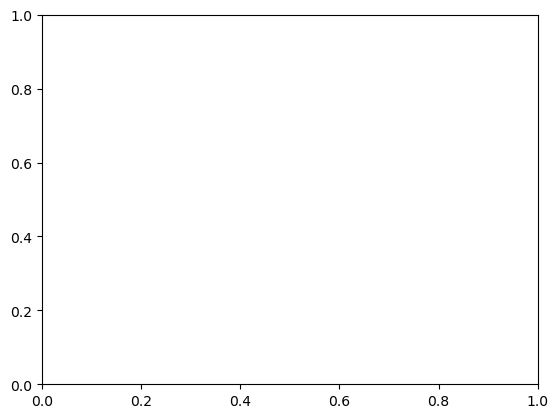

In [75]:
for tow in tc.index:
    if tow in ['PFA', 'PFc', 'PFd', 'PFl', 'PFr', 'PFs']:
        pass
    else:
        for var in ['LE', 'H']:
            if var == 'LE':
                max_bin = 2000
            else:
                max_bin = 500
            # f1 = plt.figure()
            min_bin = -max_bin

            binwidth = max_bin//25

            plt.hist(vert_ad[tow].loc[var], bins=range(min_bin, max_bin + binwidth, binwidth), density = True);
            plt.hist(vert_ad_d[tow].loc[var], bins = range(min_bin, max_bin + binwidth, binwidth), alpha = 0.7, density = True);

            plt.xlabel(var + ' [$W/m^2$]')
            plt.ylabel('Frequency')

            plt.savefig('./Outputs/d_v_0_vert_ad/' + tow + '_' + var)
            plt.cla()

In [10]:
#Approximate dates of transition between dry, wet and windy seasons

date1 = dt.datetime(2019, 7, 1)
date2 = dt.datetime(2019, 7, 12)
date3 = dt.datetime(2019, 8, 20)
date4 = dt.datetime(2019, 7, 10)

In [19]:
vert_ad1 = vert_ad[:, :]

InvalidIndexError: (slice(None, None, None), slice(None, None, None))

In [17]:
vert_ad

PFb  PFe  PFg  PFh  PFi  PFj  PFk  PFm  PFn  PFp  PFq  \
   TIMESTAMP_START                                                              
H  2019-06-01 00:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-06-01 00:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-06-01 01:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-06-01 01:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-06-01 02:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
LE 2019-10-31 21:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-10-31 22:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-10-31 22:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-10-31 23:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
   2019-10-31 23:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                        PFt  
   TIMESTAMP_START           
H  2019-06-01 00:00:00  NaN  
   2019-06-01 00:30:00  NaN  
   2019-06-01 01:00:00  NaN  
   2019-06-01 01:30:00  NaN  
   2019-06-01 02:00:00  NaN  
...                     ...  
LE 2019-10-31 21:30:00  NaN  
   2019-10-31 22:00:00  NaN  
   2019-10-31 22:30:00  NaN  
   2019-10-31 23:00:00  NaN  
   2019-10-31 23:30:00  NaN  

[14688 rows x 12 columns]

In [ ]:
plt.plot(vert_ad.loc['H'].groupby(vert_ad.loc['H'].index.hour).mean());


In [19]:


H_vert_mon = vert_ad.loc['H'].groupby(vert_ad.loc['H'].index.hour).mean()
# plt.plot(H_vert_mon.groupby(H_vert_mon.index.hour).mean());

In [10]:
tower = 'PFh'

TA_30 = TA.loc[30][tower]
TA_10 = TA.loc[10][tower]
TA_2 = TA.loc[2][tower]
TA_0 = TA_2 - (TA_10 - TA_2)*(2/8) #Surface temp
TA_diff = TA_0 - TA_30 





In [ ]:
tower = 'PFb'

#Calc vert T diff (only works for 30 m towers(only works for 30 m towers
TA_30 = TA.loc[30][tower]
TA_10 = TA.loc[10][tower]
TA_2 = TA.loc[2][tower]
TA_0 = TA_2 - (TA_10 - TA_2)*(2/8) #Surface temp
TA_diff = TA_0 - TA_30 

#Cut out upper and lower 10% of TA_diff
l_cutoff = np.nanpercentile(TA_diff, 10)
u_cutoff = np.nanpercentile(TA_diff, 90)

#TA_diff = TA_diff.where(TA_diff>l_cutoff)#.where(TA_diff<u_cutoff)
plt.hist(TA_diff, bins = 50)
plt.axvline(x = l_cutoff, color = 'r')
plt.axvline(x = u_cutoff, color = 'r')
plt.savefig('../Outputs/Poster_plots/PFh_TA_diff_hist.png')

In [ ]:
plt.plot(TA_diff.groupby(TA_diff.index.hour).mean())

In [ ]:
plt.plot(rho)
plt.xticks(rotation = 45);

In [ ]:
tower = 'PFb'
H_ad_use = vert_ad.loc['H'][tower]

vert_H_l_cut = np.nanpercentile(H_ad_use, 5)
vert_H_u_cut = np.nanpercentile(H_ad_use, 95)

# vert_H_cut = H_ad_use.where(H_ad_use >vert_H_l_cut).where(H_ad_use <vert_H_u_cut)

print(vert_H_l_cut, vert_H_u_cut)

plt.hist(H_ad_use, bins = 50)
plt.axvline(x = vert_H_l_cut, color = 'r')
plt.axvline(x = vert_H_u_cut, color = 'r')


In [ ]:

plt.hist(vert_ad.loc['H']['PFb'], bins = 100, density = True);
plt.hist(vert_ad.loc['LE']['PFb'], bins = 100, density = True, alpha = 0.7);

print(vert_ad.loc['H']['PFg'].mean(), vert_ad.loc['LE']['PFg'].mean() )

In [ ]:
time_index = np.arange(0, 24, 0.5)

In [ ]:
plt.hist(wind_tt.values.flatten(), bins = 50);

In [ ]:
vert_H = vert_ad.loc['H'][startdate:enddate]
wind_tt = vert_wind[vert_H.columns]#vert wind for tall towers

plt.scatter(wind_tt, vert_H/wind_tt);

In [ ]:
tower = 'PFm'
TA_2 = TA.loc[2][startdate:enddate][vert_H.columns]
TA_30 = TA.loc[30][startdate:enddate][vert_H.columns]
TA_0 = TA_2 - (TA_10 - TA_2)*(2/8)
TA_diff = TA_30-TA_0

TA_use = TA_diff[tower]

vert_LE = vert_ad.loc['LE'][startdate:enddate]
wind_tt = vert_wind[vert_H.columns][tower]#vert wind for tall towers

bad_indices = np.isnan(wind_tt) | np.isnan(TA_use)
good_indices = ~bad_indices
good_wind = wind_tt[good_indices]
good_TA = TA_use[good_indices]

plt.hist2d(good_wind, good_TA, bins = 50);


In [ ]:
plt.scatter(hrz_ad.loc['H'][vert_H.columns], vert_ad.loc['H'])

In [ ]:
#Note: removed changing line color by date - no decernable seasonal pattern

# cmap = plt.get_cmap('viridis').reversed()
# norm = plt.Normalize(0, len(vert_ad.loc['H'].index.date))

In [ ]:
cutoff = 50
df_precut = vert_ad.loc['H']['PFe']

df = df_precut.where(df_precut<cutoff).where(df_precut>-cutoff)
for day in vert_ad.loc['H'].index.date:

    plt.plot(time_index, df[np.in1d(df.index.date, [day])], linewidth = 0.1, color = 'lightslategray')
    plt.xlabel('Hour')
    plt.ylabel('Vertical Sensible Heat Advective Flux $W/m^2$')
    
plt.ylim(-cutoff, cutoff)

# plt.ylim(-250, 250)
plt.plot(time_index, df.groupby(df.index.time).mean(), 'k', linewidth = 3)

plt.savefig('../Outputs/Poster_plots/H_vert_PFe_daily_cut.png')

In [ ]:
cutoff = 50
df_precut = vert_ad.loc['LE']['PFe']


df = df_precut.where(df_precut<cutoff).where(df_precut>-cutoff)
for day in vert_ad.loc['LE'].index.date:
    
    plt.plot(time_index, df[np.in1d(df.index.date, [day])], linewidth = 0.2, color = 'lightslategray')
    plt.xlabel('Hour')
    plt.ylabel('Vertical Latent Heat Advective Flux $W/m^2$')
    
# plt.ylim(-500, 500)
plt.ylim(-cutoff, cutoff)
plt.plot(time_index, df.groupby(df.index.time).mean(), 'k', linewidth = 3)

plt.savefig('../Outputs/Poster_plots/LE_vert_PFe_daily_cut.png')

In [ ]:
df = hrz_ad.loc['H']['PFe']

for day in vert_ad.loc['H'].index.date:
    
    linecolor = cmap(norm(i))
    plt.plot(time_index, df[np.in1d(df.index.date, [day])], linewidth = 0.1, color = 'lightslategray')
    plt.xlabel('Hour')
    plt.ylabel('Horizontal Sensible Heat Advective Flux $W/m^2$')
    
    
    
    
plt.ylim(-8, 8)
plt.plot(time_index, df.groupby(df.index.time).mean(), 'k', linewidth = 3)

plt.savefig('../Outputs/Poster_plots/H_hrz_PFe_daily_all.png')

In [ ]:
df = hrz_ad.loc['LE']['PFe']

for day in vert_ad.loc['LE'].index.date:
    
    linecolor = cmap(norm(i))
    plt.plot(time_index, df[np.in1d(df.index.date, [day])], linewidth = 0.1, color = 'lightslategray')
    plt.xlabel('Hour')
    plt.ylabel('Horizontal Latent Heat Advective Flux $W/m^2$')
    
    
    
plt.ylim(-15, 15)
plt.plot(time_index, df.groupby(df.index.time).mean(), 'k', linewidth = 3)

plt.savefig('../Outputs/Poster_plots/LE_hrz_PFe_daily_all.png')

In [ ]:
LE_vert_day = vert_ad.loc['LE'].groupby(vert_ad.loc['LE'].index.hour).mean()
plt.plot(LE_vert_day);
plt.ylabel('Calculated Vertical Advection of Latent Heat [$W/m^2$]')
plt.xlabel('Hour')
plt.savefig('../Outputs/Poster_plots/LE_vert_ad_all.png')

In [ ]:
LE_vert_day = vert_ad.loc['H'].groupby(vert_ad.loc['H'].index.hour).mean()
plt.plot(LE_vert_day);
plt.ylabel('Calculated Vertical Advection of Sensible Heat [$W/m^2$]')
plt.xlabel('Hour')
plt.savefig('../Outputs/Poster_plots/H_vert_ad_all.png')

In [ ]:
LE_vert_day = hrz_ad.loc['H'].groupby(hrz_ad.loc['H'].index.hour).mean()
plt.plot(LE_vert_day);
plt.ylabel('Calculated Horizonta; Advection of Sensible Heat [$W/m^2$]')
plt.xlabel('Hour')
plt.savefig('../Outputs/Poster_plots/H_hrz_ad_all.png')

In [ ]:
LE_vert_day = hrz_ad.loc['LE'].groupby(hrz_ad.loc['LE'].index.hour).mean()
plt.plot(LE_vert_day);
plt.ylabel('Calculated Horizonta; Advection of Latent Heat [$W/m^2$]')
plt.xlabel('Hour')
plt.savefig('../Outputs/Poster_plots/LE_hrz_ad_all.png')

In [ ]:
def day_cyc(dat):
    dat_day = dat.groupby(dat.index.time).mean()
    return dat_day

In [ ]:
tower = 'PFi'

filepath = tc.org_path.loc[tower]
df = pd.read_csv(filepath)

df = df.applymap(lambda x: np.nan if x == -9999 else x)

dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
df.set_index(dt_ts, inplace = True)


startdate = dt.datetime(2019, 6, 20, 1)
enddate = dt.datetime(2019, 10, 14, 23)
df = df[startdate:enddate]

NETRAD = df.NETRAD_1_1_1
LE_turb = df.LE_1_1_1
H_turb = df.H_1_1_1
G = df. G_1_1_1

LE_ad_hrz = hrz_ad.loc['LE'][tower]
H_ad_hrz = hrz_ad.loc['H'][tower]

LE_ad_vert = vert_ad.loc['LE'][tower]
H_ad_vert = vert_ad.loc['H'][tower]

E_bal = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz - LE_ad_vert - H_ad_vert

E_out = LE_turb + H_turb + G + LE_ad_hrz + H_ad_hrz + LE_ad_vert + H_ad_vert

E_out_no_ad = LE_turb + H_turb + G

In [ ]:
plt.plot(np.cumsum(day_cyc(NETRAD)))
# plt.plot(day_cyc(LE_turb))
# plt.plot(day_cyc(H_turb))
# plt.plot(day_cyc(G))
# plt.plot(day_cyc(LE_ad_hrz))
# plt.plot(day_cyc(H_ad_hrz))
# plt.plot(day_cyc(LE_ad_vert))
# plt.plot(day_cyc(H_ad_vert))

plt.plot(np.cumsum(day_cyc(E_out_no_ad)))
plt.plot(np.cumsum(day_cyc(E_out)))

# plt.legend()


In [ ]:
# time_ind = hrz_ad.loc['H'].groupby(hrz_ad.loc['H'].index.time).mean().index
time_ind = np.arange(0, 24, 0.5)

fig, axs = plt.subplots(3,4, figsize = [13, 8], sharex=True, sharey=True)
for i in range(0,3):
    for j in range(0,4):
        tower = hrz_ad.columns[i*4+j +1]
        
        
        filepath = tc.org_path.loc[tower]
        df = pd.read_csv(filepath)

        df = df.applymap(lambda x: np.nan if x == -9999 else x)

        dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
        df.set_index(dt_ts, inplace = True)


        startdate = dt.datetime(2019, 6, 20, 1)
        enddate = dt.datetime(2019, 10, 14, 23)
        df = df[startdate:enddate]

        NETRAD = df.NETRAD_1_1_1
        LE_turb = df.LE_1_1_1
        H_turb = df.H_1_1_1
        G = df. G_1_1_1

        LE_ad_hrz = hrz_ad.loc['LE'][tower]
        H_ad_hrz = hrz_ad.loc['H'][tower]

        LE_ad_vert = vert_ad.loc['LE'][tower]
        H_ad_vert = vert_ad.loc['H'][tower]

        E_bal = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz - LE_ad_vert - H_ad_vert

        E_out = LE_turb + H_turb + G + LE_ad_hrz + H_ad_hrz + LE_ad_vert + H_ad_vert

        E_out_no_ad = LE_turb + H_turb + G
        
        E_out_hrz_only = LE_turb + H_turb + G + LE_ad_hrz + H_ad_hrz
        
        
        
        # axs[i, j].plot((np.cumsum(day_cyc(NETRAD).values)))
        # axs[i, j].plot((np.cumsum(day_cyc(E_out).values)))
        # axs[i, j].plot((np.cumsum(day_cyc(E_out_no_ad).values)))
        # axs[i, j].plot((np.cumsum(day_cyc(E_out_hrz_only).values)))
        
        a = axs[i, j].plot(time_ind, day_cyc(NETRAD).values, color = 'coral')
        b = axs[i, j].plot(time_ind, day_cyc(E_out).values, color = 'olivedrab')
        c = axs[i, j].plot(time_ind, day_cyc(E_out_no_ad).values, color = 'cornflowerblue')
        
        
        # axs[i, j].plot(day_cyc(E_out_hrz_only).values)
        
fig.supxlabel('Hour')
fig.supylabel('Energy Flux [$W/m^2$]')
fig.legend([a, b, c], labels = ['Net radiation', 'Turbulent, ground and advective heat fluxes', 'Turbulent and ground heat flux only'], loc="upper right")

fig.savefig('../Outputs/Poster_plots/diurnal_ebal_alltow.png')

In [ ]:
err_df = pd.DataFrame(columns = ['gap_change_med', 'gap_change_mean', 'gap_change_med_cut', 'gap_change_mean_cut'])#,
                                # 'gap_change_hrz_ad_only_med', 'gap_change_hrz_ad_only_med'])
for tower in vert_ad.columns:
    filepath = tc.org_path.loc[tower]
    df = pd.read_csv(filepath)

    df = df.applymap(lambda x: np.nan if x == -9999 else x)

    dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
    df.set_index(dt_ts, inplace = True)


    startdate = dt.datetime(2019, 6, 20, 1)
    enddate = dt.datetime(2019, 10, 14, 23)
    df = df[startdate:enddate]

    NETRAD = df.NETRAD_1_1_1
    LE_turb = df.LE_1_1_1
    H_turb = df.H_1_1_1
    G = df. G_1_1_1

    LE_ad_hrz = hrz_ad.loc['LE'][tower]
    H_ad_hrz = hrz_ad.loc['H'][tower]

    LE_ad_vert = vert_ad.loc['LE'][tower]
    H_ad_vert = vert_ad.loc['H'][tower]

    LE_ad_vert_cut = LE_ad_vert.where(LE_ad_vert>np.nanpercentile(LE_ad_vert, 10)).where(LE_ad_vert<np.nanpercentile(LE_ad_vert, 90))
    H_ad_vert_cut = H_ad_vert.where(H_ad_vert>np.nanpercentile(H_ad_vert, 10)).where(H_ad_vert<np.nanpercentile(H_ad_vert, 90))

    E_bal_org = NETRAD - LE_turb - H_turb - G

    E_bal_new = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz - LE_ad_vert - H_ad_vert

    E_bal_new_cut = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz - LE_ad_vert_cut - H_ad_vert_cut
    
    E_bal_hrz = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz

    # E_out = LE_turb + H_turb + G + LE_ad_hrz + H_ad_hrz + LE_ad_vert + H_ad_vert

    # E_out_no_ad = LE_turb + H_turb + G


    err_org = E_bal_org/NETRAD
    err_new = E_bal_new/NETRAD
    err_new_cut = E_bal_new_cut/NETRAD
    err_hrz_ad_only = E_bal_hrz/NETRAD

    # plt.hist(err_new, bins = 50, density = True);
    # plt.hist(err_org, bins = 50, alpha = .5, density = True);

    err_change = np.abs(err_org) - np.abs(err_new)
    err_change_cut = np.abs(err_org) - np.abs(err_new_cut)
    err_change_hrz_only = np.abs(err_org) - np.abs(err_hrz_ad_only)
    # plt.hist(err_change, bins = 100)
    err_df.loc[tower] = [err_change.median(), err_change.mean(), err_change_cut.median(), err_change_cut.mean()]#,
                        # err_change_hrz_only.median(), err_change_hrz_only.mean()]



In [ ]:
err_df

In [ ]:
#Example T profile plot

# tower = 'PFn'
# TA_2 = TA.loc[2][tower].mean()
# TA_10 = TA.loc[10][tower].mean()
# TA_30 = TA.loc[30][tower].mean()
# TA_0 = TA_2 - (TA_10 - TA_2)*(2/8)

# plt.figure(figsize = (8,12))

# plt.plot(TA_2, 2, marker='o', color = 'k')
# plt.plot(TA_10, 10, marker='o',color = 'k')
# plt.plot(TA_30, 30, marker='o', color = 'k')

# plt.plot([TA_0, TA_10], [0, 10], linestyle = '--', color = 'k')
# plt.plot([TA_10, TA_30], [10, 30], linestyle = '--', color = 'k')

# plt.xlabel('Air temperature (degree C)')
# plt.ylabel('Hight (m)')

# plt.savefig('./Outputs/Poster_plots/PFn_TA_prof.png')

In [ ]:
# #H and LE advection calcs



# WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW = prof_calcs('PFA')

# TA_K = TA.loc[30][tower] + CtoK

# PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
# rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
# z = step #np.asarray(tc.loc[tower].z1) #Height of each tower

# SN_wind = WS_prof*np.sin(hrz_wind.loc['WD'][tower]*np.pi/180)
# WE_wind = WS_prof*np.cos(hrz_wind.loc['WD'][tower]*np.pi/180)

# #H advection
# H_SN = T_grad_NS.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by southerly wind [W/m^2]
# H_WE = T_grad_EW.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by westerly wind [W/m^2]
# H_ad = H_SN + H_WE #Total advection

# #LE advection
# LE_SN = H2O_grad_NS.mul(-z*L*SN_wind/2000, axis = 0)#Advection of latend heat by southerly wind [W/m^2]
# LE_WE = H2O_grad_EW.mul(-z*L*WE_wind/2000, axis = 0)#Advection of latent hear by westerly wind [W/m^2]
# LE_ad = (LE_SN + LE_WE)#*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


# # hrz_ad = (H_ad + LE_ad)
# H_ad_tot = H_ad.sum(axis = 1)
# LE_ad_tot = LE_ad.sum(axis = 1)



In [ ]:
##Plot wind profile at one time step
# WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW = prof_calcs('PFb', 0.1)

# z_range = np.arange(0, 30.01, 0.1)

# plt.plot(WS_prof.iloc[1005], z_range)

In [ ]:
#Advection time series

# tower = 'PFb'
# # plt.plot(vert_ad.loc['H'][tower])
# fig, axs = plt.subplots(4)
# axs[0].plot(hrz_ad.loc['H'][tower])
# axs[1].plot(hrz_ad.loc['LE'][tower])
# axs[2].plot(vert_ad.loc['H'][tower])
# axs[3].plot(vert_ad.loc['LE'][tower])
# fig.tight_layout()
# plt.savefig('./Outputs/Poster_plots/PFb_ad_all.png')

In [ ]:
H_day = hrz_ad.loc['H'].groupby(hrz_ad.loc['H'].index.hour).mean()
plt.plot(H_day)